In [2]:
%cd ./image-recognition-with-synthetic-training-data/model

/root/image-recognition-with-synthetic-training-data/model


In [3]:
%load_ext autoreload
%autoreload 2

In [5]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import boto3
from sagemaker.s3 import S3Uploader, S3Downloader
from PIL import Image



# Root directory of the project
ROOT_DIR = os.path.abspath(".")
print(ROOT_DIR)
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from src.VehiclesDataset import VehiclesDataset

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'models')

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, 'models/mask_rcnn_coco.h5')
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/root/image-recognition-with-synthetic-training-data/model


## Configuration

In [6]:
class VehiclesConfig(Config):
    NAME = "vehicles"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 6
    NUM_CLASSES = 1 + 2  # background + 2 shapes
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    #BACKBONE = "resnet50" -- default is resnet101

    #These are for BW
    #IMAGE_CHANNEL_COUNT = 1
    #MEAN_PIXEL = 1
    
    #Faster epochs?
    #STEPS_PER_EPOCH = 100
config = VehiclesConfig()
#config.display()

## Create training and validation datasets

In [14]:
train_dataset_dir = '../../data/color/train'
val_dataset_dir = '../../data/color/val'
mask_dir = '../../data/masks/'


# Training dataset
dataset_train = VehiclesDataset()
dataset_train.load_images(train_dataset_dir, mask_dir)
dataset_train.prepare()

# Validation dataset
dataset_val = VehiclesDataset()
dataset_val.load_images(val_dataset_dir, mask_dir)
dataset_val.prepare()

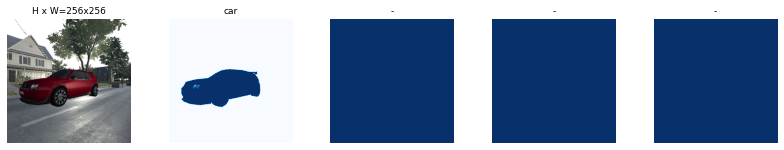

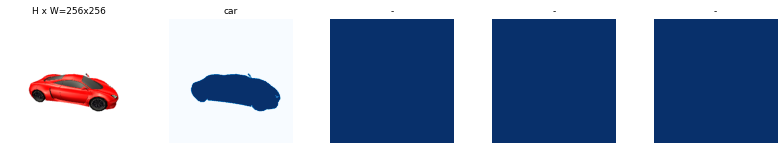

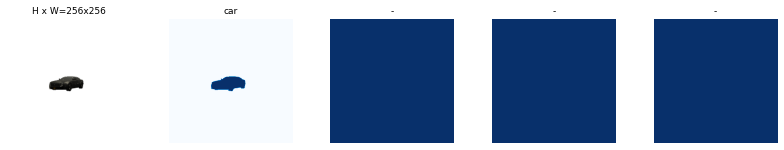

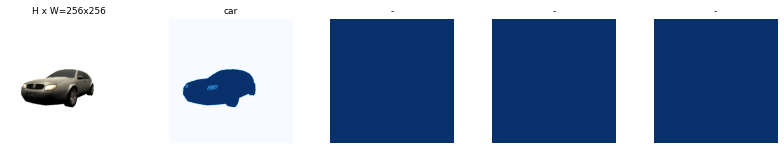

In [16]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create model in training mode

In [10]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


## Load weights file to take advantage of transfer learning

In [ ]:
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    
    #The excluded layers are used when there are a large number of classes
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
#    model_path = model.find_last()
    model_path = os.path.join(MODEL_DIR, "mask_rcnn_vehicles10.h5")
    print('loading model from: {}'.format(model_path))
    model.load_weights(model_path, by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')

In [ ]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=5, 
            layers="all")

In [20]:
# Save weights
model_path = os.path.join(MODEL_DIR, "mask_rcnn_vehicles.h5")
model.keras_model.save_weights(model_path)